<b>PLEASE NOTE THAT THIS NOTEBOOK WAS RUN IN GOOGLE COLAB AS SUCH CERTAIN IMPORT STATEMENTS MAY DIFFER</b>

In [1]:
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import os
import pandas as pd
import numpy as np
import math


Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

train_path=os.path.abspath(os.path.join(os.path.dirname("__file__"), '..', '/content/drive/My Drive/datasets/train.csv'))
training_df = pd.read_csv(train_path, index_col="tripid")


In [0]:
training_df = training_df.dropna()

In [0]:
def dist_from_coordinates(lat1, lon1, lat2, lon2):
  R = 6371  # Earth radius in km

  #conversion to radians
  d_lat = np.radians(lat2-lat1)
  d_lon = np.radians(lon2-lon1)

  r_lat1 = np.radians(lat1)
  r_lat2 = np.radians(lat2)

  #haversine formula
  a = np.sin(d_lat/2.) **2 + np.cos(r_lat1) * np.cos(r_lat2) * np.sin(d_lon/2.)**2

  haversine = 2 * R * np.arcsin(np.sqrt(a))

  return haversine

In [0]:
training_df['pickup_time'] = pd.to_datetime(training_df['pickup_time'], format="%m/%d/%Y %H:%M")
training_df['drop_time'] = pd.to_datetime(training_df['drop_time'], format="%m/%d/%Y %H:%M")

In [0]:
training_df = training_df.assign(timeOfDay=pd.cut(training_df.pickup_time.dt.hour,[-1, 8, 20, 24],labels=['dawn','day', 'night']))

In [0]:
durations = []
for index,row in training_df.iterrows():
  provided_duration = row['duration'] #first row of location.lat column here
  if math.isnan(provided_duration) or provided_duration <= 0 :
    time_dif = (row['drop_time'] - row['pickup_time']).seconds
    if(time_dif == 0):
        time_dif = np.nan
    durations.append(time_dif)
  else :  
    durations.append(provided_duration)

training_df.insert(4,"time_dif",durations)

In [0]:
new_column = []                    #empty column for distance
for index,row in training_df.iterrows():
  lat1 = row['pick_lat'] #first row of location.lat column here
  lon1 = row['pick_lon'] #first row of location.long column here
  lat2 = row['drop_lat'] #second row of location.lat column here
  lon2 = row['drop_lon'] #second row of location.long column here
  value = dist_from_coordinates(lat1, lon1, lat2, lon2)  #get the distance
  new_column.append(value)   #append the empty list with distance values

training_df.insert(4,"distance",new_column)

In [0]:
training_df['time_driven'] = training_df['duration']  - training_df['meter_waiting']

In [0]:
chargeperhours = []
for index,row in training_df.iterrows():
    if(row['meter_waiting'] == 0):
        chargeperhour = 0
    else:
        chargeperhour = (row['meter_waiting_fare'] / row['meter_waiting'])
    chargeperhours.append(chargeperhour)

training_df.insert(4,'charge_per_hour',chargeperhours)


In [0]:
training_df['driving_fare'] = training_df['fare']  - training_df['meter_waiting_fare'] - training_df['additional_fare']

In [0]:
avgspeeds = []
for index,row in training_df.iterrows():
    if(row['time_driven'] == 0):
        avgspeed = 0    
    else:
        avgspeed = (row['distance'] / row['time_driven'])
    avgspeeds.append(avgspeed)

training_df.insert(4,"avg_speed",avgspeeds)



In [0]:
costsperkm = []
for index,row in training_df.iterrows():
    if row['driving_fare'] == 0:
        costperkm = 0
            
    else:
        costperkm = (row['distance'] / row['driving_fare'])
    costsperkm.append(costperkm)

training_df.insert(4,"cost_per_km",costsperkm)

In [15]:
training_df.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'cost_per_km', 'avg_speed', 'charge_per_hour', 'distance', 'time_dif',
       'meter_waiting_till_pickup', 'pickup_time', 'drop_time', 'pick_lat',
       'pick_lon', 'drop_lat', 'drop_lon', 'fare', 'label', 'timeOfDay',
       'time_driven', 'driving_fare'],
      dtype='object')

In [0]:
training_features_labels = ['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'cost_per_km', 'avg_speed', 'distance', 'time_dif',
       'meter_waiting_till_pickup', 'fare',
       'time_driven', 'charge_per_hour', 'driving_fare']

In [0]:
correct_training_df = training_df[training_df['label'] == 'correct']

In [0]:
correct_training_df = correct_training_df[training_features_labels ]

In [18]:
correct_training_df.isnull().sum()

additional_fare              0
duration                     0
meter_waiting                0
meter_waiting_fare           0
cost_per_km                  0
avg_speed                    0
distance                     0
time_dif                     0
meter_waiting_till_pickup    0
fare                         0
time_driven                  0
charge_per_hour              0
driving_fare                 0
dtype: int64

In [0]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = MinMaxScaler()
# scaled_seqs = scaler.fit_transform(correct_training_df )
scaled_seqs = correct_training_df
#Create a test and train sets of our data
X_train = scaled_seqs[:12000]
X_test = scaled_seqs[12000:]

In [0]:
tensorboard = TensorBoard(write_images=True)

In [0]:
input_dim = X_train.shape[1] # the # features
encoding_dim = 8 # first layer
hidden_dim = int(encoding_dim / 2) #hideen layer

nb_epoch = 30
batch_size = 128
learning_rate = 0.1

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='tanh')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# ----- some data omitted --------- #



In [0]:
autoencoder.compile(loss='mean_squared_error', optimizer='sgd')

In [0]:
history = autoencoder.fit(X_train, X_train,
                    epochs=10000,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(X_test, X_test),
                    verbose=1,
                    callbacks=[tensorboard]).history

Streaming output truncated to the last 5000 lines.
Epoch 5489/10000
12000/12000 [==============================] - 0s 13us/step - loss: 1530845.1168 - val_loss: 14571678.4522
Epoch 5490/10000
12000/12000 [==============================] - 0s 13us/step - loss: 1530845.0803 - val_loss: 14571678.4522
Epoch 5491/10000
12000/12000 [==============================] - 0s 13us/step - loss: 1530845.1220 - val_loss: 14571678.4522
Epoch 5492/10000
12000/12000 [==============================] - 0s 13us/step - loss: 1530845.0847 - val_loss: 14571678.4522
Epoch 5493/10000
12000/12000 [==============================] - 0s 13us/step - loss: 1530845.1297 - val_loss: 14571678.4522
Epoch 5494/10000
12000/12000 [==============================] - 0s 13us/step - loss: 1530845.1667 - val_loss: 14571678.4522
Epoch 5495/10000
12000/12000 [==============================] - 0s 13us/step - loss: 1530845.0652 - val_loss: 14571678.4522
Epoch 5496/10000
12000/12000 [==============================] - 0s 13us/step - lo

In [0]:
incorrect_training_df = training_df[training_df['label'] == 'incorrect']

In [0]:
 = incorrect_training_df[training_features_labels ]

In [0]:
scaled_data_testing = MinMaxScaler().fit_transform(incorrect_training_df)

In [0]:
predicted = autoencoder.predict(scaled_data_testing)

In [0]:
mse = np.mean(np.power(scaled_data_testing - predicted, 2), axis=1)

In [0]:
incorrect_training_df['anomaly_prediction'] = mse 

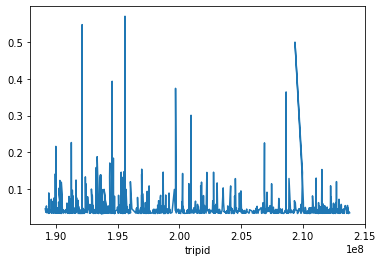

In [48]:
incorrect_training_df['anomaly_prediction'].plot()

In [0]:
predicted_correct = autoencoder.predict(scaled_seqs)

In [0]:
mse_cor = np.mean(np.power(scaled_seqs - predicted_correct, 2), axis=1)

In [0]:
correct_training_df['anomaly_prediction'] = mse_cor

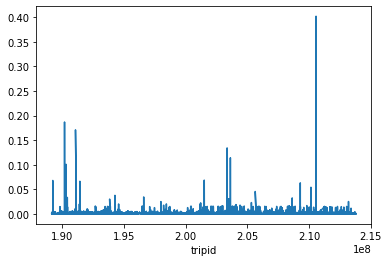

In [52]:
correct_training_df['anomaly_prediction'].plot()

In [0]:
training_df = training_df[training_features_labels]

In [0]:
scaled_full = MinMaxScaler().fit_transform(training_df)

In [0]:
predicted_full = autoencoder.predict(scaled_full)

In [58]:
predicted_full.shape

(16968, 13)

In [0]:
mse = np.mean(np.power(scaled_full - predicted_full, 2), axis=1)

In [60]:
training_df['pred'] = mse

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [61]:
training_df

,additional_fare,duration,meter_waiting,meter_waiting_fare,cost_per_km,avg_speed,distance,time_dif,meter_waiting_till_pickup,fare,time_driven,charge_per_hour,driving_fare,pred
tripid,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,0.019601,0.006546,5.092770,834.0,64.0,270.32,778.0,0.0000,259.8200,0.041286
189125358,10.5,791.0,47.0,0.0000,0.016910,0.004258,3.168058,791.0,134.0,197.85,744.0,0.0000,187.3500,0.041818
189125719,10.5,1087.0,80.0,0.0000,0.021658,0.006262,6.305395,1087.0,61.0,301.64,1007.0,0.0000,291.1400,0.041265
189127273,10.5,598.0,271.0,15.6638,0.015355,0.002636,0.861946,598.0,68.0,82.30,327.0,0.0578,56.1362,0.035657
189129552,10.5,3407.0,182.0,0.0000,0.022956,0.007506,24.207039,3407.0,112.0,1065.02,3225.0,0.0000,1054.5200,0.040784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,0.011547,0.002826,2.105376,838.0,451.0,198.26,745.0,0.0583,182.3381,0.035611
213812756,10.5,2151.0,428.0,0.0000,0.019043,0.006308,10.868377,2151.0,39.0,581.23,1723.0,0.0000,570.7300,0.040546
213813930,10.5,263.0,9.0,0.0000,0.015914,0.004116,1.045518,263.0,110.0,76.20,254.0,0.0000,65.7000,0.042246


In [0]:

training_df_temp = pd.read_csv(train_path, index_col="tripid")


In [0]:
training_df_temp = training_df_temp.dropna()

In [0]:
training_df_temp['pred'] = mse

In [67]:
training_df_temp[training_df_temp['label'] == 'correct']

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label,pred
tripid,,,,,,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,correct,0.041286
189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,correct,0.041818
189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,correct,0.041265
189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,correct,0.035657
189129552,10.5,3407.0,182.0,0.0000,112.0,11/1/2019 5:38,11/1/2019 6:35,7.13402,79.8969,6.91865,79.8649,1065.02,correct,0.040784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213803193,10.5,838.0,93.0,5.4219,451.0,1/31/2020 22:07,1/31/2020 22:21,7.29073,80.6367,7.28891,80.6557,198.26,correct,0.035611
213812756,10.5,2151.0,428.0,0.0000,39.0,1/31/2020 23:07,1/31/2020 23:43,6.90569,79.8516,6.95089,79.9389,581.23,correct,0.040546
213813930,10.5,263.0,9.0,0.0000,110.0,1/31/2020 23:21,1/31/2020 23:25,7.09210,79.9000,7.10135,79.9017,76.20,correct,0.042246
